## Facebook prophet
- Univariate
- A procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [1]:
from darts import TimeSeries
from darts.models import Prophet
from darts.utils.statistics import plot_hist
from darts.metrics import mape
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')

In [3]:
df = df.drop(['date', 'day_of_week', 'time', 'month'], axis=1)

In [4]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, time_col="datetime", value_cols='energy_price')

splitting_point = (int(len(series)*0.20))

# Set aside the second half of series as a validation series
train, val = series[:-splitting_point], series[-splitting_point:]
# train, val = series.split_before(0.75)

In [6]:
model = Prophet()

In [15]:
model.fit(train)

forecast = model.predict(len(val))
print(f'model {model} obtains MAPE: {mape(val, forecast):.2f}%')

16:43:07 - cmdstanpy - INFO - Chain [1] start processing
16:43:11 - cmdstanpy - INFO - Chain [1] done processing


model Prophet obtains MAPE: 1550.68%


## Historical forecasts
Forecasting using historical data.

*Backtesting: General method for seeing how well a model would have done using historical data.

In [7]:
historical_fcast = model.historical_forecasts(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    overlap_end=False,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

14:46:14 - cmdstanpy - INFO - Chain [1] start processing
14:46:19 - cmdstanpy - INFO - Chain [1] done processing
14:46:19 - cmdstanpy - INFO - Chain [1] start processing
14:46:23 - cmdstanpy - INFO - Chain [1] done processing
14:46:24 - cmdstanpy - INFO - Chain [1] start processing
14:46:28 - cmdstanpy - INFO - Chain [1] done processing
14:46:28 - cmdstanpy - INFO - Chain [1] start processing
14:46:31 - cmdstanpy - INFO - Chain [1] done processing
14:46:32 - cmdstanpy - INFO - Chain [1] start processing
14:46:34 - cmdstanpy - INFO - Chain [1] done processing
14:46:35 - cmdstanpy - INFO - Chain [1] start processing
14:46:38 - cmdstanpy - INFO - Chain [1] done processing
14:46:38 - cmdstanpy - INFO - Chain [1] start processing
14:46:40 - cmdstanpy - INFO - Chain [1] done processing
14:46:41 - cmdstanpy - INFO - Chain [1] start processing
14:46:43 - cmdstanpy - INFO - Chain [1] done processing
14:46:43 - cmdstanpy - INFO - Chain [1] start processing
14:46:46 - cmdstanpy - INFO - Chain [1]

MAPE = 39.36%


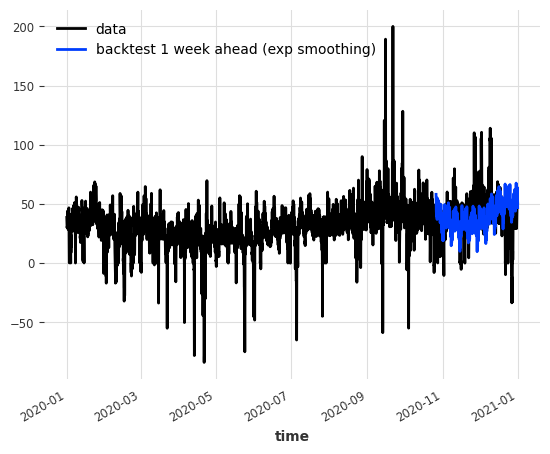

In [8]:
series.plot(label='data')
historical_fcast.plot(label='backtest 1 week ahead (exp smoothing)')
print(f'MAPE = {mape(historical_fcast, series):.2f}%')

## Backtest
It repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

In [9]:
raw_errors = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=None,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

15:03:17 - cmdstanpy - INFO - Chain [1] start processing
15:03:19 - cmdstanpy - INFO - Chain [1] done processing
15:03:19 - cmdstanpy - INFO - Chain [1] start processing
15:03:20 - cmdstanpy - INFO - Chain [1] done processing
15:03:20 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] done processing
15:03:23 - cmdstanpy - INFO - Chain [1] start processing
15:03:24 - cmdstanpy - INFO - Chain [1] done processing
15:03:24 - cmdstanpy - INFO - Chain [1] start processing
15:03:25 - cmdstanpy - INFO - Chain [1] done processing
15:03:25 - cmdstanpy - INFO - Chain [1] start processing
15:03:27 - cmdstanpy - INFO - Chain [1] done processing
15:03:27 - cmdstanpy - INFO - Chain [1] start processing
15:03:28 - cmdstanpy - INFO - Chain [1] done processing
15:03:29 - cmdstanpy - INFO - Chain [1] start processing
15:03:31 - cmdstanpy - INFO - Chain [1] done processing
15:03:31 - cmdstanpy - INFO - Chain [1] start processing
15:03:33 - cmdstanpy - INFO - Chain [1]

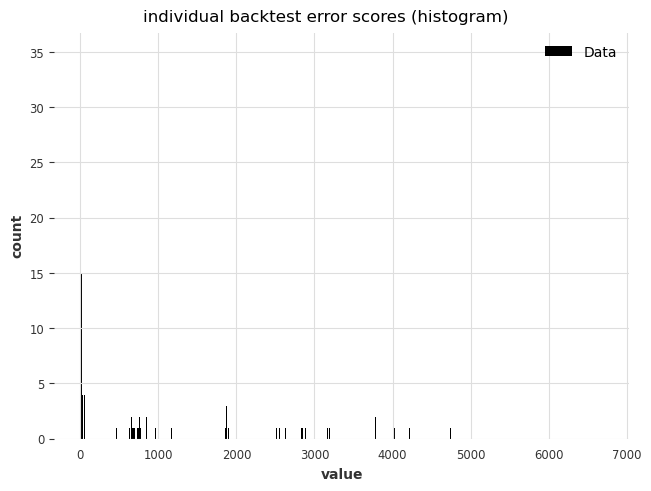

In [10]:
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title='individual backtest error scores (histogram)'
)

In [11]:
median_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=np.median,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

15:40:06 - cmdstanpy - INFO - Chain [1] start processing
15:40:07 - cmdstanpy - INFO - Chain [1] done processing
15:40:07 - cmdstanpy - INFO - Chain [1] start processing
15:40:08 - cmdstanpy - INFO - Chain [1] done processing
15:40:08 - cmdstanpy - INFO - Chain [1] start processing
15:40:09 - cmdstanpy - INFO - Chain [1] done processing
15:40:09 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] done processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:12 - cmdstanpy - INFO - Chain [1] done processing
15:40:12 - cmdstanpy - INFO - Chain [1] start processing
15:40:12 - cmdstanpy - INFO - Chain [1] done processing
15:40:13 - cmdstanpy - INFO - Chain [1] start processing
15:40:13 - cmdstanpy - INFO - Chain [1] done processing
15:40:14 - cmdstanpy - INFO - Chain [1] start processing
15:40:15 - cmdstanpy - INFO - Chain [1]

In [12]:
print(f'Median error (MAPE) over all historical forecasts: {median_error:.2f}%')

Median error (MAPE) over all historical forecasts: 49.37%


In [13]:
average_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=np.mean,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:18 - cmdstanpy - INFO - Chain [1] start processing
16:14:19 - cmdstanpy - INFO - Chain [1] done processing
16:14:19 - cmdstanpy - INFO - Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing
16:14:21 - cmdstanpy - INFO - Chain [1] start processing
16:14:23 - cmdstanpy - INFO - Chain [1] done processing
16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:25 - cmdstanpy - INFO - Chain [1] done processing
16:14:25 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing
16:14:28 - cmdstanpy - INFO - Chain [1] start processing
16:14:30 - cmdstanpy - INFO - Chain [1]

In [14]:
print(f'Average error (MAPE) over all historical forecasts: {average_error:.2f}%')

Average error (MAPE) over all historical forecasts: 976.11%
